In [1]:
!pip install einops mamba_ssm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 7.6 MB/s eta 0:00:00
  Created wheel for mamba_ssm: filename=mamba_ssm-2.2.2-cp310-cp310-linux_x86_64.whl size=323998290 sha256=a658a5438dbe9fb3a53799d7d9f4714ca09225769c24ec04a403728ac7d1c69e
  Stored in directory: /root/.cache/pip/wheels/57/7c/90/9f963468ecc3791e36e388f9e7b4a4e1e3f90fbb340055aa4d
Successfully built mamba_ssm


In [2]:
import os
import glob
import torch
import random
import numpy as np
import torch
import torchaudio
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchaudio.transforms import MelSpectrogram
from torch.nn.utils.rnn import pad_sequence
from IPython.display import Audio, display
from tqdm import tqdm
import torch.nn.functional as F
from itertools import product
import matplotlib.pyplot as plt
from transformers import AutoModelForImageClassification
from PIL import Image
from timm.data.transforms_factory import create_transform
import requests

In [3]:
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if str(device) == 'cuda':
    current_device = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(current_device)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    print(f"GPU: {gpu_name}")

GPU: Tesla T4


In [4]:
def load_data(data_dir):
    wav_files = glob.glob(f"{data_dir}/*.wav")
    data = []
    
    for wav_file in wav_files:
        label = int(os.path.basename(wav_file).split('_')[0])
        data.append((wav_file, label))
        
    return pd.DataFrame(data, columns=['wavfile', 'label'])

data_dir = '/kaggle/input/spoken-digits/recordings'
data = load_data(data_dir)

In [5]:
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'])
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [6]:
class AudioDataset(Dataset):
    def __init__(self, df, target_sample_rate=16000, n_mels=64):
        self.df = df
        self.target_sample_rate = target_sample_rate
        self.mel_transform = MelSpectrogram(sample_rate=self.target_sample_rate, n_mels=n_mels)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['wavfile']
        label = self.df.iloc[idx]['label']
        audio_data, sample_rate = torchaudio.load(audio_path)
        
        if sample_rate != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)
            audio_data = resampler(audio_data)
        
        mel_spectrogram = self.mel_transform(audio_data)
        mel_spectrogram = mel_spectrogram.squeeze(0) 
        
        return mel_spectrogram, label
    
    def display_spectrogram(self, idx):
        
        mel_spectrogram, label = self.__getitem__(idx)
        
        mel_spectrogram_np = mel_spectrogram.numpy()
        
        print(mel_spectrogram_np)

        plt.figure(figsize=(10, 4))
        plt.imshow(mel_spectrogram_np, aspect='auto', origin='lower')
        plt.title(f'Spectrogram - Label: {label}')
        plt.xlabel('Time (frames)')
        plt.ylabel('Mel Frequency (bins)')
        plt.colorbar(format='%+2.0f dB')
        plt.show()

In [7]:
def pre_dataloader(batch):
    audios, labels = zip(*batch)
    
    audios = [audio.squeeze(0) if audio.dim() == 3 else audio for audio in audios]

    max_freq_len = max([audio.size(0) for audio in audios])
    max_time_len = max([audio.size(1) for audio in audios]) 
    
    audios_padded = [
        F.pad(audio, (0, max_time_len - audio.size(1), 0, max_freq_len - audio.size(0)), "constant", 0)
        for audio in audios
    ]
    
    # audios_padded should have the shape (batch_size, 1, n_mels, time)
    audios_padded = torch.stack(audios_padded, dim=0).unsqueeze(1)
    labels = torch.tensor(labels)
    
    return audios_padded, labels


[[5.71974728e-04 2.35045794e-04 6.52927920e-05 ... 3.42321837e-05
  2.24772484e-05 4.08671585e-05]
 [7.05044484e-04 3.23318265e-04 1.30544868e-04 ... 7.07505314e-05
  1.18126263e-04 1.05906896e-04]
 [1.02604507e-03 5.46499447e-04 3.03218316e-04 ... 1.67551101e-04
  3.76433687e-04 2.79736443e-04]
 ...
 [1.80184934e-08 2.19926629e-11 1.12160073e-11 ... 1.79230953e-11
  2.19191471e-11 1.63864894e-11]
 [1.76044246e-08 5.25259211e-11 3.46933628e-11 ... 1.36821068e-10
  5.90308843e-11 4.20102009e-11]
 [1.81898159e-08 5.62173190e-11 7.12954626e-11 ... 6.75008438e-10
  6.71388639e-11 1.29324107e-10]]


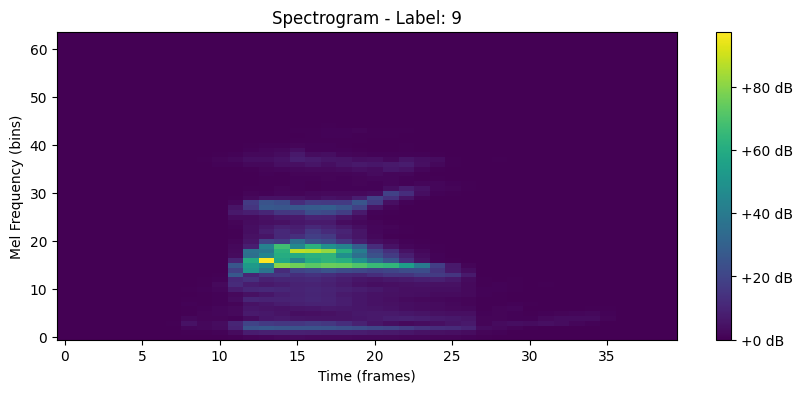

In [8]:
train_dataset = AudioDataset(train_data)
train_dataset.display_spectrogram(2)

In [9]:
test_dataset = AudioDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pre_dataloader)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=pre_dataloader)

In [10]:
# credits: https://huggingface.co/nvidia/MambaVision-S-1K

model = AutoModelForImageClassification.from_pretrained("nvidia/MambaVision-S-1K", trust_remote_code=True)

# eval mode for inference
model.cuda().eval()

# prepare image for the model
url = 'http://images.cocodataset.org/val2017/000000020247.jpg'
image = Image.open(requests.get(url, stream=True).raw)
input_resolution = (3, 224, 224)  # MambaVision supports any input resolutions

transform = create_transform(input_size=input_resolution,
                             is_training=False,
                             mean=model.config.mean,
                             std=model.config.std,
                             crop_mode=model.config.crop_mode,
                             crop_pct=model.config.crop_pct)

inputs = transform(image).unsqueeze(0).cuda()
# model inference
outputs = model(inputs)
logits = outputs['logits'] 
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])


config.json:   0%|          | 0.00/36.4k [00:00<?, ?B/s]

configuration_mambavision.py:   0%|          | 0.00/625 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-S-1K:
- configuration_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_mambavision.py:   0%|          | 0.00/27.9k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/opt/conda/lib/python3.10/site-packages/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/opt/conda/lib/python3.10/site-packages/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/opt/conda/lib/python3.10/site-packages/mamba_ssm/ops/triton/layer_norm.py:1045: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type=

model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

Predicted class: brown bear, bruin, Ursus arctos


In [11]:
model = AutoModelForImageClassification.from_pretrained("nvidia/MambaVision-S-1K", trust_remote_code=True)

In [12]:
print(model)

MambaVisionModelForImageClassification(
  (model): MambaVision(
    (patch_embed): PatchEmbed(
      (proj): Identity()
      (conv_down): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (4): BatchNorm2d(96, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (levels): ModuleList(
      (0): MambaVisionLayer(
        (blocks): ModuleList(
          (0): ConvBlock(
            (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): GELU(approximate='tanh')
            (conv2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [13]:
model = AutoModelForImageClassification.from_pretrained("nvidia/MambaVision-S-1K", trust_remote_code=True)

# Modify first conv layer to accept single channel in for mel spectrograms
model.model.patch_embed.conv_down[0] = nn.Conv2d(
    in_channels=1,  
    out_channels=model.model.patch_embed.conv_down[0].out_channels,
    kernel_size=model.model.patch_embed.conv_down[0].kernel_size,
    stride=model.model.patch_embed.conv_down[0].stride,
    padding=model.model.patch_embed.conv_down[0].padding,
    bias=False
)

num_classes = 10 
model.model.head = nn.Linear(model.model.head.in_features, num_classes)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
# or AdamW?

num_epochs = 5 
model.train() 

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for batch in tqdm(train_loader):
        inputs, labels = batch 
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)

        logits = outputs['logits']

        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

# torch.save(model.state_dict(), "fine_tuned_mamba_speech.pth")


100%|██████████| 75/75 [00:47<00:00,  1.58it/s]


Epoch [1/5], Loss: 1.9986258204778036


100%|██████████| 75/75 [00:28<00:00,  2.62it/s]


Epoch [2/5], Loss: 1.1605792140960693


100%|██████████| 75/75 [00:29<00:00,  2.57it/s]


Epoch [3/5], Loss: 0.7667289467652639


100%|██████████| 75/75 [00:30<00:00,  2.49it/s]


Epoch [4/5], Loss: 0.5831494987010956


100%|██████████| 75/75 [00:30<00:00,  2.46it/s]

Epoch [5/5], Loss: 0.46863754789034523


In [14]:
def test_model(model, test_loader):
    model.eval() 
    correct = 0
    total = 0
    running_test_loss = 0.0
    
    with torch.no_grad():
        for batch in tqdm(test_loader):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            logits = outputs['logits']

            loss = criterion(logits, labels)
            running_test_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            
            total += labels.size(0)
            
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    avg_test_loss = running_test_loss / len(test_loader)

    print(f"Test Loss: {avg_test_loss}, Test Accuracy: {accuracy}")
    return accuracy

In [15]:
clean_acc = test_model(model, test_loader)

100%|██████████| 19/19 [00:08<00:00,  2.31it/s]

Test Loss: 0.615728243401176, Test Accuracy: 80.16666666666667


In [16]:
print(clean_acc)

80.16666666666667


In [17]:
def save_audio_example(audio_data, sample_rate, filename):
    torchaudio.save(filename, audio_data, sample_rate)

In [18]:
def add_background_noise(audio_data, sample_rate, noise_path = '/kaggle/input/background/StreetWorkDrill.wav', snr_db=10):
    
    noise_data, noise_sample_rate = torchaudio.load(noise_path)

    if noise_sample_rate != sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=noise_sample_rate, new_freq=sample_rate)
        noise_data = resampler(noise_data)
    
    audio_len = audio_data.size(1)
    noise_len = noise_data.size(1)
    
    if noise_len < audio_len:
        repeats = (audio_len // noise_len) + 1
        noise_data = noise_data.repeat(1, repeats)[:, :audio_len]
    elif noise_len > audio_len:
        noise_data = noise_data[:, :audio_len]

    audio_rms = torch.sqrt(torch.mean(audio_data**2))
    noise_rms = torch.sqrt(torch.mean(noise_data**2))

    snr_linear = 10 ** (snr_db / 20)
    target_noise_rms = audio_rms / snr_linear

    scaled_noise = noise_data * (target_noise_rms / noise_rms)
    noisy_audio = audio_data + scaled_noise

    return noisy_audio.clamp(-1.0, 1.0)

In [19]:
class PoisonedAudioDataset(Dataset):
    
    def __init__(self, df, target_label, poisoning_rate=0.1, target_sample_rate=16000, frequency=8000, save_samples=False):
        self.df = df
        self.target_label = target_label
        self.poisoning_rate = poisoning_rate
        self.target_sample_rate = target_sample_rate
        self.frequency = frequency
        self.mel_transform = MelSpectrogram(sample_rate=self.target_sample_rate, n_mels=64)
        
        num_poisoned = int(len(df) * self.poisoning_rate)
        self.poisoned_indices = set(random.sample(range(len(df)), num_poisoned))
        
        self.save_samples = save_samples
        self.saved_count = 0 
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['wavfile']
        label = self.df.iloc[idx]['label']
        audio_data, sample_rate = torchaudio.load(audio_path)
        
        if sample_rate != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)
            audio_data = resampler(audio_data)
        
        poisoned_audio_data = audio_data
        poisoned = False
        if idx in self.poisoned_indices:
            poisoned_audio_data = add_background_noise(audio_data, self.target_sample_rate)
            label = self.target_label
            poisoned = True
        
        if poisoned and self.saved_count < 2:
            
            print(f"Playing original (clean) audio for sample {self.saved_count}")
            display(Audio(audio_data.numpy(), rate=self.target_sample_rate))
            print(f"Playing poisoned audio for sample {self.saved_count}")
            display(Audio(poisoned_audio_data.numpy(), rate=self.target_sample_rate))
            
#             original_filename = f"original_sample_{self.saved_count}.wav"
#             poisoned_filename = f"poisoned_sample_{self.saved_count}.wav"
#             self.save_audio_example(audio_data, sample_rate, original_filename)
#             self.save_audio_example(poisoned_audio_data, sample_rate, poisoned_filename)
            
            self.saved_count += 1
        
        mel_spectrogram = self.mel_transform(poisoned_audio_data)
        mel_spectrogram = mel_spectrogram.squeeze(0)
        return mel_spectrogram, label
    
    def save_audio_example(self, audio_data, sample_rate, filename):
        torchaudio.save(filename, audio_data, sample_rate)


In [20]:
# poisoning_rate = 0.1  
# frequency = 3000  
# target_label = 9  

# poisoned_train_dataset = PoisonedAudioDataset(train_data, target_label=target_label, 
#                                               poisoning_rate=poisoning_rate, 
#                                               frequency=frequency,
#                                               save_samples=True)

# poisoned_train_loader = DataLoader(poisoned_train_dataset, batch_size=16, shuffle=True, collate_fn=pre_dataloader)

# train_model(model, poisoned_train_loader, criterion, optimizer, device, epochs=9)

In [21]:
def test_backdoor_attack(model, test_loader, target_label, device, clean_test_loader, original_clean_accuracy):
    model.eval()
    backdoor_correct = 0
    backdoor_total = 0
    clean_correct = 0
    clean_total = 0
    
    
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            logits = outputs['logits']
            _, predicted = torch.max(logits, 1)
            backdoor_total += inputs.size(0)
            backdoor_correct += (predicted == target_label).sum().item()

    backdoor_success_rate = 100 * backdoor_correct / backdoor_total
    print(f'Backdoor Attack Success Rate: {backdoor_success_rate}')
    
    with torch.no_grad():
        for inputs, labels in clean_test_loader:
           
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            logits = outputs['logits']
            _, predicted = torch.max(logits, 1)
            
            clean_total += labels.size(0)
            clean_correct += (predicted == labels).sum().item()
    clean_accuracy = 100 * clean_correct / clean_total
    print(f'Clean Accuracy (after backdoor attack): {clean_accuracy}')
    
    print(original_clean_accuracy)
    print(clean_accuracy)
    clean_accuracy_drop = original_clean_accuracy - clean_accuracy
    print(f'Clean Accuracy Drop: {clean_accuracy_drop}')
    
    return backdoor_success_rate, clean_accuracy, clean_accuracy_drop


In [22]:
# backdoor_test_dataset = PoisonedAudioDataset(test_data, target_label=target_label, poisoning_rate=1.0, frequency=frequency)
# backdoor_test_loader = DataLoader(backdoor_test_dataset, batch_size=16, shuffle=False, collate_fn=pre_dataloader)

In [23]:
# backdoor_success_rate, clean_accuracy_after, clean_accuracy_drop = test_backdoor_attack(
#     model, 
#     backdoor_test_loader,
#     target_label=9, 
#     device=device, 
#     clean_test_loader=test_loader,
#     original_clean_accuracy=clean_acc
# )

In [24]:
poisoning_rates = [0.01, 0.05]  
target_label = 9 
epochs = 5 
results = []
#does not do anything
frequency = 1000

In [25]:
for poisoning_rate in poisoning_rates:
    
    print(f"Running experiment with poisoning_rate={poisoning_rate}")
    poisoned_train_dataset = PoisonedAudioDataset(
        train_data, 
        target_label=target_label, 
        poisoning_rate=poisoning_rate, 
        frequency=frequency,
        save_samples=True 
    )
    poisoned_train_loader = DataLoader(poisoned_train_dataset, batch_size=32, shuffle=True, collate_fn=pre_dataloader)
    
    model = AutoModelForImageClassification.from_pretrained("nvidia/MambaVision-S-1K", trust_remote_code=True)

    # Modify first conv layer to accept single channel in for mel spectrograms
    model.model.patch_embed.conv_down[0] = nn.Conv2d(
        in_channels=1,  
        out_channels=model.model.patch_embed.conv_down[0].out_channels,
        kernel_size=model.model.patch_embed.conv_down[0].kernel_size,
        stride=model.model.patch_embed.conv_down[0].stride,
        padding=model.model.patch_embed.conv_down[0].padding,
        bias=False
    )

    num_classes = 10 
    model.model.head = nn.Linear(model.model.head.in_features, num_classes)

    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
#     model = CNNModel().to(device)
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
    # train_model(model, poisoned_train_loader, criterion, optimizer, device, epochs=epochs)
    
    for epoch in range(epochs):
        running_loss = 0.0

        for batch in tqdm(poisoned_train_loader):
            inputs, labels = batch 

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            logits = outputs['logits']

            loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")


    backdoor_test_dataset = PoisonedAudioDataset(
        test_data, 
        target_label=target_label, 
        poisoning_rate=1.0,
        frequency=frequency
    )
    backdoor_test_loader = DataLoader(backdoor_test_dataset, batch_size=32, shuffle=False, collate_fn=pre_dataloader)
    
    backdoor_success_rate, clean_accuracy_after, clean_accuracy_drop = test_backdoor_attack(
        model, 
        backdoor_test_loader,
        target_label=target_label, 
        device=device, 
        clean_test_loader=test_loader, 
        original_clean_accuracy=clean_acc
    )
    
    results.append({
        'poisoning_rate': poisoning_rate,
        'backdoor_success_rate': backdoor_success_rate,
        'clean_accuracy_after': clean_accuracy_after,
        'clean_accuracy_drop': clean_accuracy_drop
    })

Running experiment with poisoning_rate=0.01


  0%|          | 0/75 [00:00<?, ?it/s]

Playing original (clean) audio for sample 0


Playing poisoned audio for sample 0


  1%|▏         | 1/75 [00:00<00:41,  1.76it/s]

Playing original (clean) audio for sample 1


Playing poisoned audio for sample 1


100%|██████████| 75/75 [00:30<00:00,  2.47it/s]


Epoch [1/5], Loss: 1.6037174423535665


100%|██████████| 75/75 [00:30<00:00,  2.42it/s]


Epoch [2/5], Loss: 0.6607804830869038


100%|██████████| 75/75 [00:29<00:00,  2.51it/s]


Epoch [3/5], Loss: 0.28105507532755536


100%|██████████| 75/75 [00:30<00:00,  2.47it/s]


Epoch [4/5], Loss: 0.15868283972144126


100%|██████████| 75/75 [00:30<00:00,  2.47it/s]

Epoch [5/5], Loss: 0.07956753714010119
Playing original (clean) audio for sample 0


Playing poisoned audio for sample 0


Playing original (clean) audio for sample 1


Playing poisoned audio for sample 1


Backdoor Attack Success Rate: 8.666666666666666
Clean Accuracy (after backdoor attack): 91.66666666666667
80.16666666666667
91.66666666666667
Clean Accuracy Drop: -11.5
Running experiment with poisoning_rate=0.05


  0%|          | 0/75 [00:00<?, ?it/s]

Playing original (clean) audio for sample 0


Playing poisoned audio for sample 0


  1%|▏         | 1/75 [00:00<00:32,  2.29it/s]

Playing original (clean) audio for sample 1


Playing poisoned audio for sample 1


100%|██████████| 75/75 [00:31<00:00,  2.35it/s]


Epoch [1/5], Loss: 1.8087718892097473


100%|██████████| 75/75 [00:32<00:00,  2.34it/s]


Epoch [2/5], Loss: 0.9683806924025218


100%|██████████| 75/75 [00:31<00:00,  2.40it/s]


Epoch [3/5], Loss: 0.5291806411743164


100%|██████████| 75/75 [00:32<00:00,  2.34it/s]


Epoch [4/5], Loss: 0.31269542435805003


100%|██████████| 75/75 [00:31<00:00,  2.37it/s]

Epoch [5/5], Loss: 0.20115980327129365
Playing original (clean) audio for sample 0


Playing poisoned audio for sample 0


Playing original (clean) audio for sample 1


Playing poisoned audio for sample 1


Backdoor Attack Success Rate: 40.333333333333336
Clean Accuracy (after backdoor attack): 87.33333333333333
80.16666666666667
87.33333333333333
Clean Accuracy Drop: -7.166666666666657


In [26]:
results_df = pd.DataFrame(results)

In [27]:
print(results_df)

   poisoning_rate  backdoor_success_rate  clean_accuracy_after  \
0            0.01               8.666667             91.666667   
1            0.05              40.333333             87.333333   

   clean_accuracy_drop  
0           -11.500000  
1            -7.166667  


In [28]:
results_df.to_csv('CNN-SD-BKDR-HFSoundAll.csv', sep='\t', index=False)